# Phase 2: Hierarchical Stitching Method

This notebook implements the hierarchical stitching method using constrained optimization.

**Method**: Hierarchical (Constrained Optimization)

**Algorithm**:
1. Each chunk gets a scaling factor (alpha_k)
2. Build constraint matrix:
   - Monthly constraints (hard): scaled daily sums match monthly ground truth
   - Weekly constraints (weighted): scaled daily sums match weekly ground truth
   - Overlap constraints (soft): overlapping values should be similar
3. Solve least squares problem using LSQR

**Expected Performance**: Best accuracy. Target MAE < 3% vs monthly ground truth.

**Outputs**:
- `interim/hierarchical/stitched_series.parquet`
- `interim/hierarchical/alpha_estimates.pkl`
- `interim/hierarchical/diagnostics.pkl`

## 0. Setup

In [1]:
# Setup
import sys
from pathlib import Path

# Add src to path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root / "src"))

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from loguru import logger

from config import ConfigManager
from utils import FileManager, setup_logger
from stitching import HierarchicalStitcher, BaselineStitcher, StitchingResult

# Configure plotting
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)

print("✓ Imports successful")

✓ Imports successful


In [3]:
# Load configuration
config = ConfigManager(
    config_path=project_root / "config.yaml",
    env_path=project_root / ".env"
)
file_manager = FileManager(project_root)
file_manager.ensure_directories()

# Setup logging
log_file = file_manager.get_log_path("hierarchical_stitching.log")
setup_logger(log_file, level="INFO")

print(config.summary())

2025-11-12 23:46:38.902 | INFO     | config:__init__:221 - Loaded environment variables from /home/mikhailarutyunov/projects/google-trends-daily-data-preprocessing/.env
2025-11-12 23:46:38.906 | INFO     | config:__init__:232 - Loaded configuration from /home/mikhailarutyunov/projects/google-trends-daily-data-preprocessing/config.yaml
2025-11-12 23:46:38.906 | SUCCESS  | config:_parse_config:319 - Configuration validated successfully
2025-11-12 23:46:38.908 | INFO     | utils:ensure_directories:50 - Ensured all directories exist under /home/mikhailarutyunov/projects/google-trends-daily-data-preprocessing
2025-11-12 23:46:38 | INFO     | Logging to file: /home/mikhailarutyunov/projects/google-trends-daily-data-preprocessing/logs/hierarchical_stitching.log


Configuration Summary
Search Term: flu vaccine
Geographic Location: GB
Date Range: 2022-01-01 to 2024-12-31 (1096 days)
Overlap: 60 days
Random Seed: 42

Stitching Weights:
  Monthly: 1.0
  Weekly: 0.5
  Overlap: 0.1

Zero Handling:
  Threshold: 0.01
  Structural Zero Months: [6, 7, 8]

Optimization:
  Max Iterations: 1000
  Tolerance: 1e-08

SerpAPI:
  Timeout: 90s
  Max Retries: 3
  Retry Delay: 10s


## 1. Load Data

Load the data collected in Phase 1.

In [4]:
# Load monthly data
monthly_path = file_manager.get_raw_data_path("monthly")
if not monthly_path.exists():
    raise FileNotFoundError(
        f"Monthly data not found at {monthly_path}. "
        "Please run notebook 01_data_collection.ipynb first."
    )

monthly_data = pd.read_parquet(monthly_path)
print(f"Loaded monthly data: {len(monthly_data)} months")
print(f"Date range: {monthly_data['date'].min()} to {monthly_data['date'].max()}")
monthly_data.head()

Loaded monthly data: 263 months
Date range: 2004-01-01 00:00:00 to 2025-11-01 00:00:00


,date,value,is_partial
0,2004-01-01,2,False
1,2004-02-01,2,False
2,2004-03-01,1,False
3,2004-04-01,1,False
4,2004-05-01,0,False


In [5]:
# Load weekly data
weekly_path = file_manager.get_raw_data_path("weekly")
weekly_data = None

if weekly_path.exists():
    weekly_data = pd.read_parquet(weekly_path)
    print(f"Loaded weekly data: {len(weekly_data)} weeks")
    print(f"Date range: {weekly_data['date'].min()} to {weekly_data['date'].max()}")
    display(weekly_data.head())
else:
    print("⚠ Weekly data not found. Hierarchical method works best with weekly data for additional constraints.")

Loaded weekly data: 158 weeks
Date range: 2021-12-26 00:00:00 to 2024-12-29 00:00:00


,date,value,is_partial
0,2021-12-26,0.604251,False
1,2022-01-02,0.743693,False
2,2022-01-09,0.650732,False
3,2022-01-16,0.697213,False
4,2022-01-23,0.464808,False


In [6]:
# Load daily chunks
daily_chunks = []
chunk_idx = 0

while True:
    chunk_path = file_manager.get_daily_chunk_path(chunk_idx)
    if not chunk_path.exists():
        break

    chunk = pd.read_parquet(chunk_path)
    daily_chunks.append(chunk)
    chunk_idx += 1

if not daily_chunks:
    raise FileNotFoundError(
        f"No daily chunks found in {file_manager.data_daily_chunks}. "
        "Please run notebook 01_data_collection.ipynb first."
    )

print(f"Loaded {len(daily_chunks)} daily chunks")
print(f"Total observations: {sum(len(c) for c in daily_chunks)}")
print(f"Date range: {min(c['date'].min() for c in daily_chunks)} to {max(c['date'].max() for c in daily_chunks)}")

# Show chunk information
chunk_info = pd.DataFrame([
    {
        "chunk_id": i,
        "start": chunk["date"].min(),
        "end": chunk["date"].max(),
        "days": len(chunk),
        "mean_value": chunk["value"].mean(),
    }
    for i, chunk in enumerate(daily_chunks)
])
display(chunk_info)

Loaded 6 daily chunks
Total observations: 1396
Date range: 2022-01-01 00:00:00 to 2024-12-31 00:00:00


,chunk_id,start,end,days,mean_value
0,0,2022-01-01,2022-09-23,266,0.381283
1,1,2022-07-26,2023-04-17,266,0.627491
2,2,2023-02-17,2023-11-09,266,0.709794
3,3,2023-09-11,2024-06-02,266,0.799610
4,4,2024-04-04,2024-12-25,266,0.920181
5,5,2024-10-27,2024-12-31,66,2.403623


## 2. Run Hierarchical Stitching

Apply the hierarchical stitching method with constrained optimization.

In [7]:
# Initialize hierarchical stitcher
stitcher = HierarchicalStitcher()

# Run stitching
logger.info("Starting hierarchical stitching...")
result = stitcher.stitch(daily_chunks, monthly_data, weekly_data, config)
logger.success("Hierarchical stitching completed")

# Display results summary
print(f"\nStitched series: {len(result.stitched_series)} days")
print(f"Date range: {result.stitched_series['date'].min()} to {result.stitched_series['date'].max()}")
print(f"Alpha estimates: {len(result.alpha_estimates)} chunks")
print(f"\nDiagnostics:")
print(f"  Monthly MAE: {result.diagnostics.get('monthly_mae', 'N/A'):.2f}")
print(f"  Monthly RMSE: {result.diagnostics.get('monthly_rmse', 'N/A'):.2f}")
if 'monthly_corr' in result.diagnostics:
    print(f"  Monthly Correlation: {result.diagnostics['monthly_corr']:.3f}")
if 'monthly_bias_pct' in result.diagnostics:
    print(f"  Monthly Bias: {result.diagnostics['monthly_bias_pct']:.1f}%")
if 'weekly_mae' in result.diagnostics:
    print(f"  Weekly MAE: {result.diagnostics['weekly_mae']:.2f}")
    print(f"  Weekly RMSE: {result.diagnostics['weekly_rmse']:.2f}")
    if 'weekly_corr' in result.diagnostics:
        print(f"  Weekly Correlation: {result.diagnostics['weekly_corr']:.3f}")
    if 'weekly_bias_pct' in result.diagnostics:
        print(f"  Weekly Bias: {result.diagnostics['weekly_bias_pct']:.1f}%")
print(f"  Alpha mean: {result.diagnostics['alpha_mean']:.3f}")
print(f"  Alpha std: {result.diagnostics['alpha_std']:.3f}")
print(f"  Alpha CV: {result.diagnostics['alpha_cv']:.3f}")

# Optimization info
opt_info = result.diagnostics['optimization']
print(f"\nOptimization:")
print(f"  Status: {opt_info['stop_reason']}")
print(f"  Converged: {opt_info['converged']}")
print(f"  Iterations: {opt_info['iterations']}")
print(f"  Residual norm: {opt_info['residual_norm']:.6f}")

# Constraint info
const_info = result.diagnostics['constraints']
print(f"\nConstraints:")
print(f"  Monthly: {const_info['num_monthly']}")
print(f"  Weekly: {const_info['num_weekly']}")
print(f"  Overlap: {const_info['num_overlap']}")
print(f"  Total: {const_info['total']} constraints × {const_info['num_chunks']} variables")

2025-11-12 23:46:45 | INFO     | Starting hierarchical stitching...
2025-11-12 23:46:45 | INFO     | Starting hierarchical stitching method
2025-11-12 23:46:45 | INFO     | Step 1: Building daily data index
2025-11-12 23:46:45 | INFO     | Built daily index: 1396 observations, 6 chunks, 1096 unique dates
2025-11-12 23:46:45 | INFO     | Step 2: Building constraint matrices
2025-11-12 23:46:45 | INFO     | Adding monthly constraints
2025-11-12 23:46:45 | INFO     | Added 36 monthly constraints
2025-11-12 23:46:45 | INFO     | Adding weekly constraints
2025-11-12 23:46:45 | INFO     | Added 157 weekly constraints
2025-11-12 23:46:45 | INFO     | Adding overlap constraints
2025-11-12 23:46:45 | INFO     | Added 300 overlap constraints
2025-11-12 23:46:45 | INFO     | Built constraint system: 493 constraints × 6 variables, sparsity=0.289
2025-11-12 23:46:45 | INFO     | Step 3: Solving optimization problem
2025-11-12 23:46:45 | INFO     | Solving LSQR with max_iter=1000, tol=1e-08
2025-11-


Stitched series: 1096 days
Date range: 2022-01-01 00:00:00 to 2024-12-31 00:00:00
Alpha estimates: 6 chunks

Diagnostics:
  Monthly MAE: 2.92
  Monthly RMSE: 3.58
  Monthly Correlation: 0.935
  Monthly Bias: -40.7%
  Weekly MAE: 0.36
  Weekly RMSE: 0.62
  Weekly Correlation: 0.902
  Weekly Bias: 3.6%
  Alpha mean: 0.167
  Alpha std: 0.136
  Alpha CV: 0.810

Optimization:
  Status: x approximately solves least-squares problem
  Converged: True
  Iterations: 6
  Residual norm: 16.246816

Constraints:
  Monthly: 36
  Weekly: 157
  Overlap: 300
  Total: 493 constraints × 6 variables


## 3. Compare with Baseline

Load baseline results for comparison (if available).

In [8]:
# Try to load baseline results for comparison
try:
    baseline_result = StitchingResult.load(file_manager, "baseline")
    print("✓ Baseline results loaded for comparison")

    # Create comparison table
    comparison = pd.DataFrame([
        {
            "Method": "Baseline",
            "Monthly MAE": baseline_result.diagnostics.get('monthly_mae', np.nan),
            "Monthly RMSE": baseline_result.diagnostics.get('monthly_rmse', np.nan),
            "Monthly R²": baseline_result.diagnostics.get('monthly_r2', np.nan),
            "Weekly MAE": baseline_result.diagnostics.get('weekly_mae', np.nan),
            "Alpha CV": baseline_result.diagnostics.get('alpha_cv', np.nan),
        },
        {
            "Method": "Hierarchical",
            "Monthly MAE": result.diagnostics.get('monthly_mae', np.nan),
            "Monthly RMSE": result.diagnostics.get('monthly_rmse', np.nan),
            "Monthly R²": result.diagnostics.get('monthly_r2', np.nan),
            "Weekly MAE": result.diagnostics.get('weekly_mae', np.nan),
            "Alpha CV": result.diagnostics.get('alpha_cv', np.nan),
        },
    ])

    # Calculate improvements
    if not np.isnan(comparison.loc[0, 'Monthly MAE']):
        improvement = 100 * (comparison.loc[0, 'Monthly MAE'] - comparison.loc[1, 'Monthly MAE']) / comparison.loc[0, 'Monthly MAE']
        print(f"\n📊 Hierarchical method improves Monthly MAE by {improvement:.1f}% over baseline")

    display(comparison.round(3))

except FileNotFoundError:
    print("⚠ Baseline results not found. Run notebook 02 first for comparison.")
    baseline_result = None

2025-11-12 23:47:01 | INFO     | Loaded stitching results for baseline


✓ Baseline results loaded for comparison

📊 Hierarchical method improves Monthly MAE by -658028752709996928.0% over baseline


,Method,Monthly MAE,Monthly RMSE,Monthly R²,Weekly MAE,Alpha CV
0,Baseline,0.000,0.000,1.000,0.700,0.721
1,Hierarchical,2.922,3.577,0.662,0.358,0.810


## 4. Visualize Results

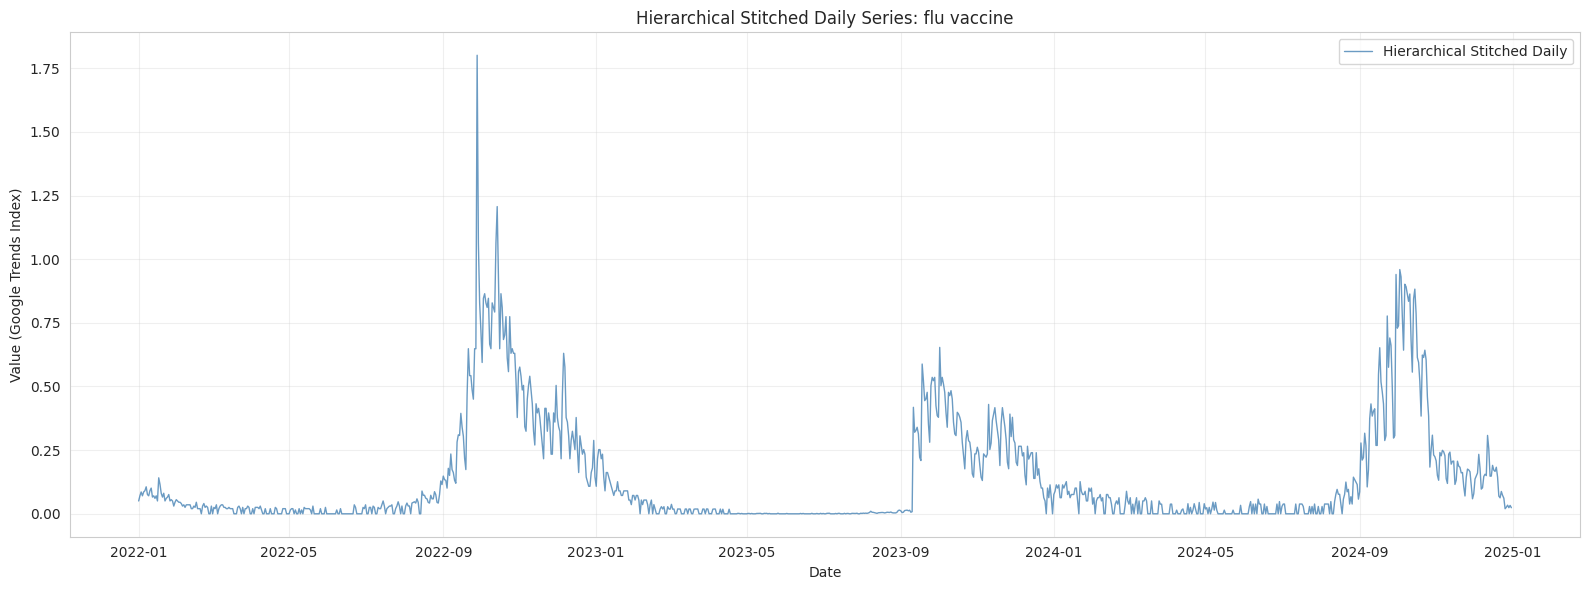

In [9]:
# Plot stitched daily series
fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(result.stitched_series['date'], result.stitched_series['value'],
        linewidth=1, alpha=0.8, label='Hierarchical Stitched Daily', color='steelblue')
ax.set_xlabel('Date')
ax.set_ylabel('Value (Google Trends Index)')
ax.set_title(f'Hierarchical Stitched Daily Series: {config.search_term}')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

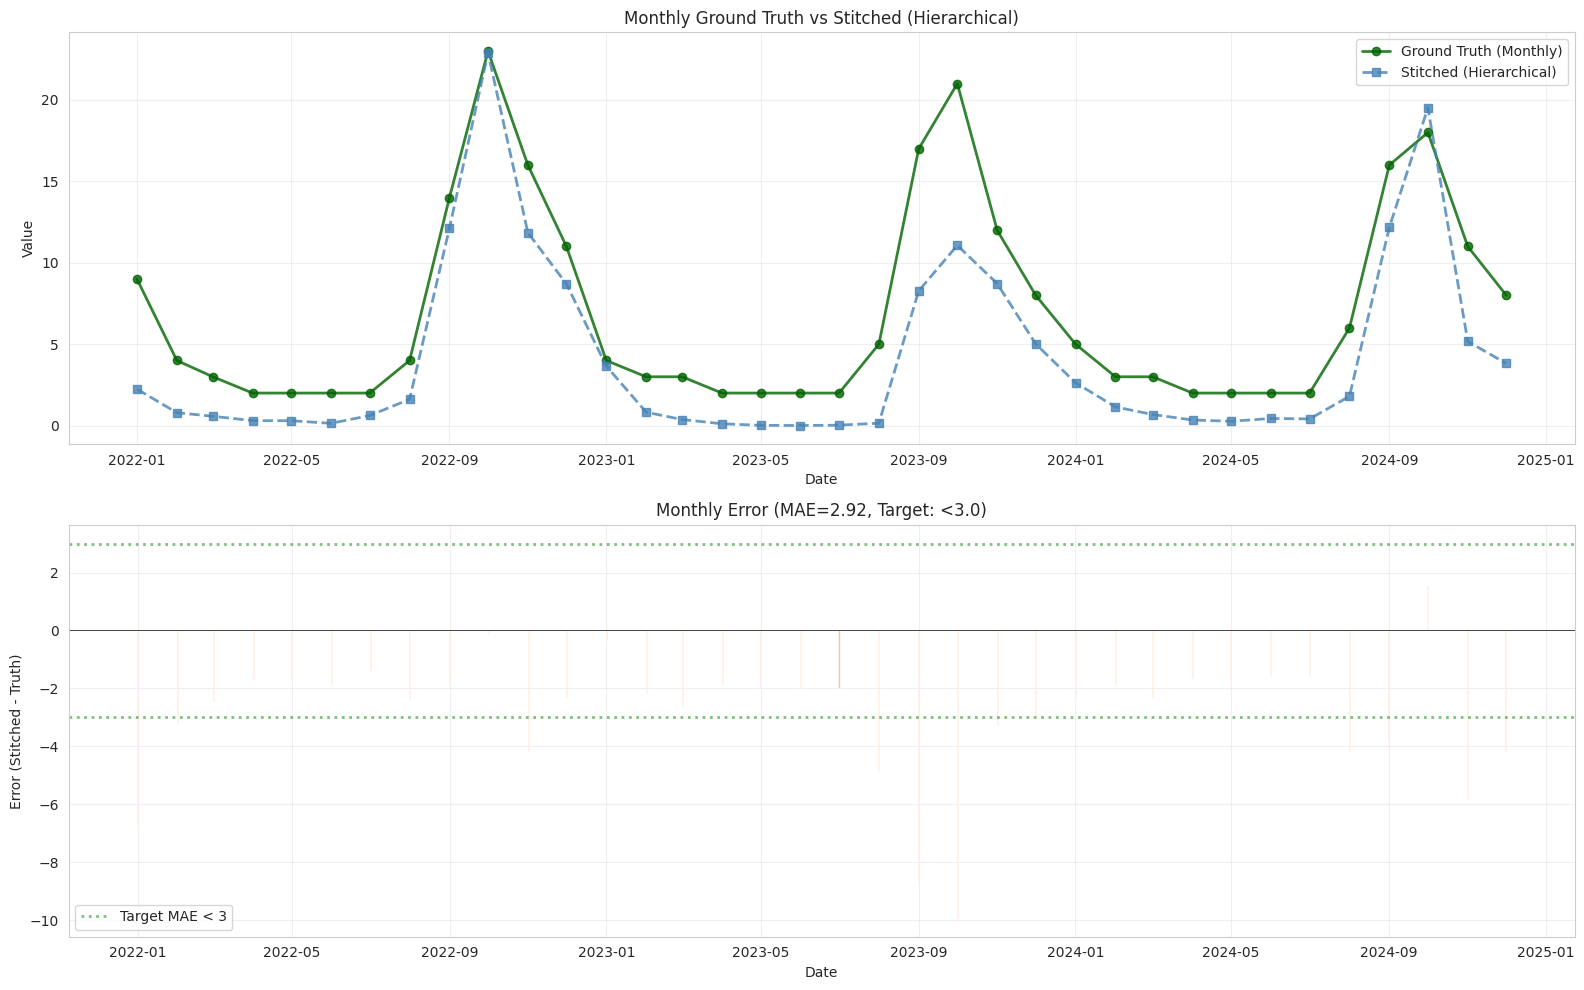

In [10]:
# Plot monthly comparison
if 'monthly_comparison' in result.diagnostics:
    monthly_comp = result.diagnostics['monthly_comparison']

    fig, axes = plt.subplots(2, 1, figsize=(16, 10))

    # Actual vs stitched
    axes[0].plot(monthly_comp['date'], monthly_comp['truth'],
                 marker='o', linewidth=2, label='Ground Truth (Monthly)', alpha=0.8, color='darkgreen')
    axes[0].plot(monthly_comp['date'], monthly_comp['stitched'],
                 marker='s', linewidth=2, linestyle='--', label='Stitched (Hierarchical)', alpha=0.8, color='steelblue')
    axes[0].set_xlabel('Date')
    axes[0].set_ylabel('Value')
    axes[0].set_title('Monthly Ground Truth vs Stitched (Hierarchical)')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Error plot
    axes[1].bar(monthly_comp['date'], monthly_comp['error'], alpha=0.7, color='coral')
    axes[1].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    axes[1].set_xlabel('Date')
    axes[1].set_ylabel('Error (Stitched - Truth)')
    axes[1].set_title(f"Monthly Error (MAE={result.diagnostics['monthly_mae']:.2f}, Target: <3.0)")
    axes[1].grid(True, alpha=0.3)

    # Add target line
    axes[1].axhline(y=3, color='green', linestyle=':', linewidth=2, alpha=0.5, label='Target MAE < 3')
    axes[1].axhline(y=-3, color='green', linestyle=':', linewidth=2, alpha=0.5)
    axes[1].legend()

    plt.tight_layout()
    plt.show()

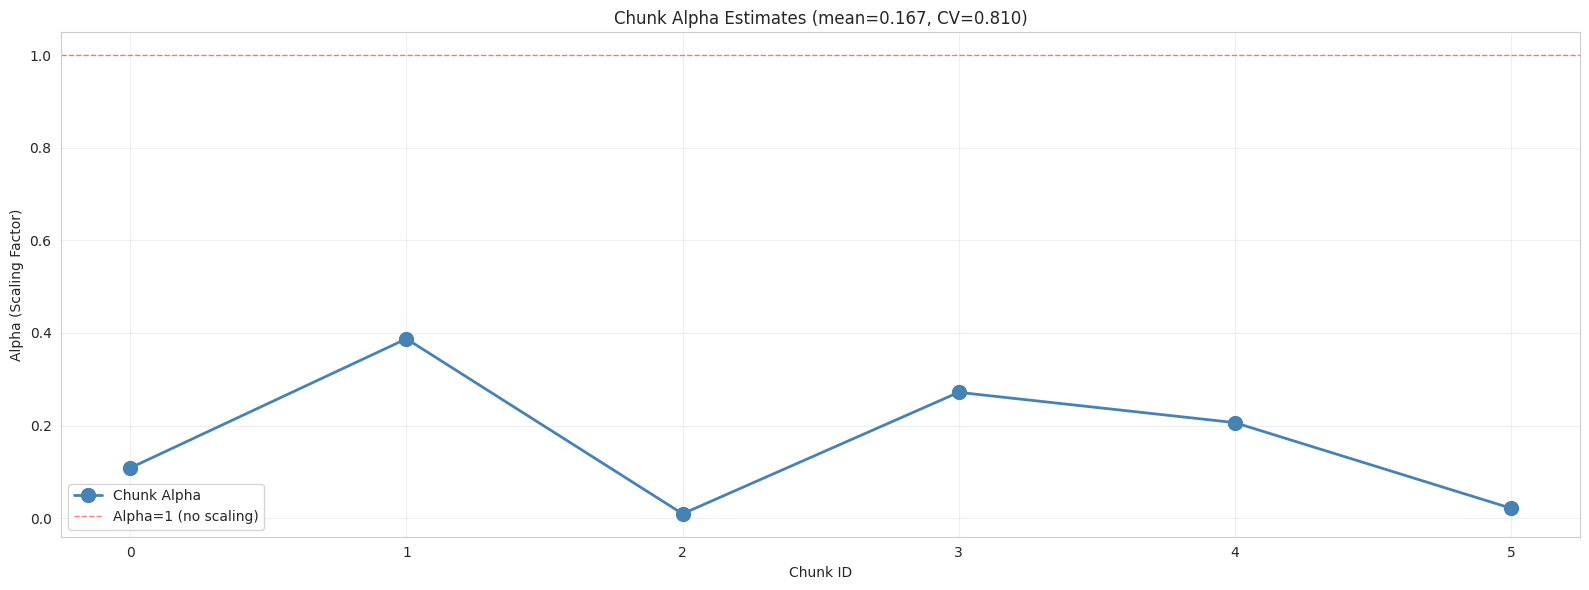

,Chunk ID,Alpha
0,0,0.108547
1,1,0.387442
2,2,0.009410
3,3,0.271787
4,4,0.206357
5,5,0.021453


In [11]:
# Plot alpha estimates per chunk
fig, ax = plt.subplots(figsize=(16, 6))
chunk_ids = range(len(result.alpha_estimates))
ax.plot(chunk_ids, result.alpha_estimates,
        marker='o', linewidth=2, markersize=10, label='Chunk Alpha', color='steelblue')
ax.axhline(y=1, color='red', linestyle='--', linewidth=1, alpha=0.5, label='Alpha=1 (no scaling)')
ax.set_xlabel('Chunk ID')
ax.set_ylabel('Alpha (Scaling Factor)')
ax.set_title(f'Chunk Alpha Estimates (mean={result.diagnostics["alpha_mean"]:.3f}, CV={result.diagnostics["alpha_cv"]:.3f})')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_xticks(chunk_ids)
plt.tight_layout()
plt.show()

# Print alpha values
alpha_df = pd.DataFrame({
    'Chunk ID': chunk_ids,
    'Alpha': result.alpha_estimates,
})
display(alpha_df)

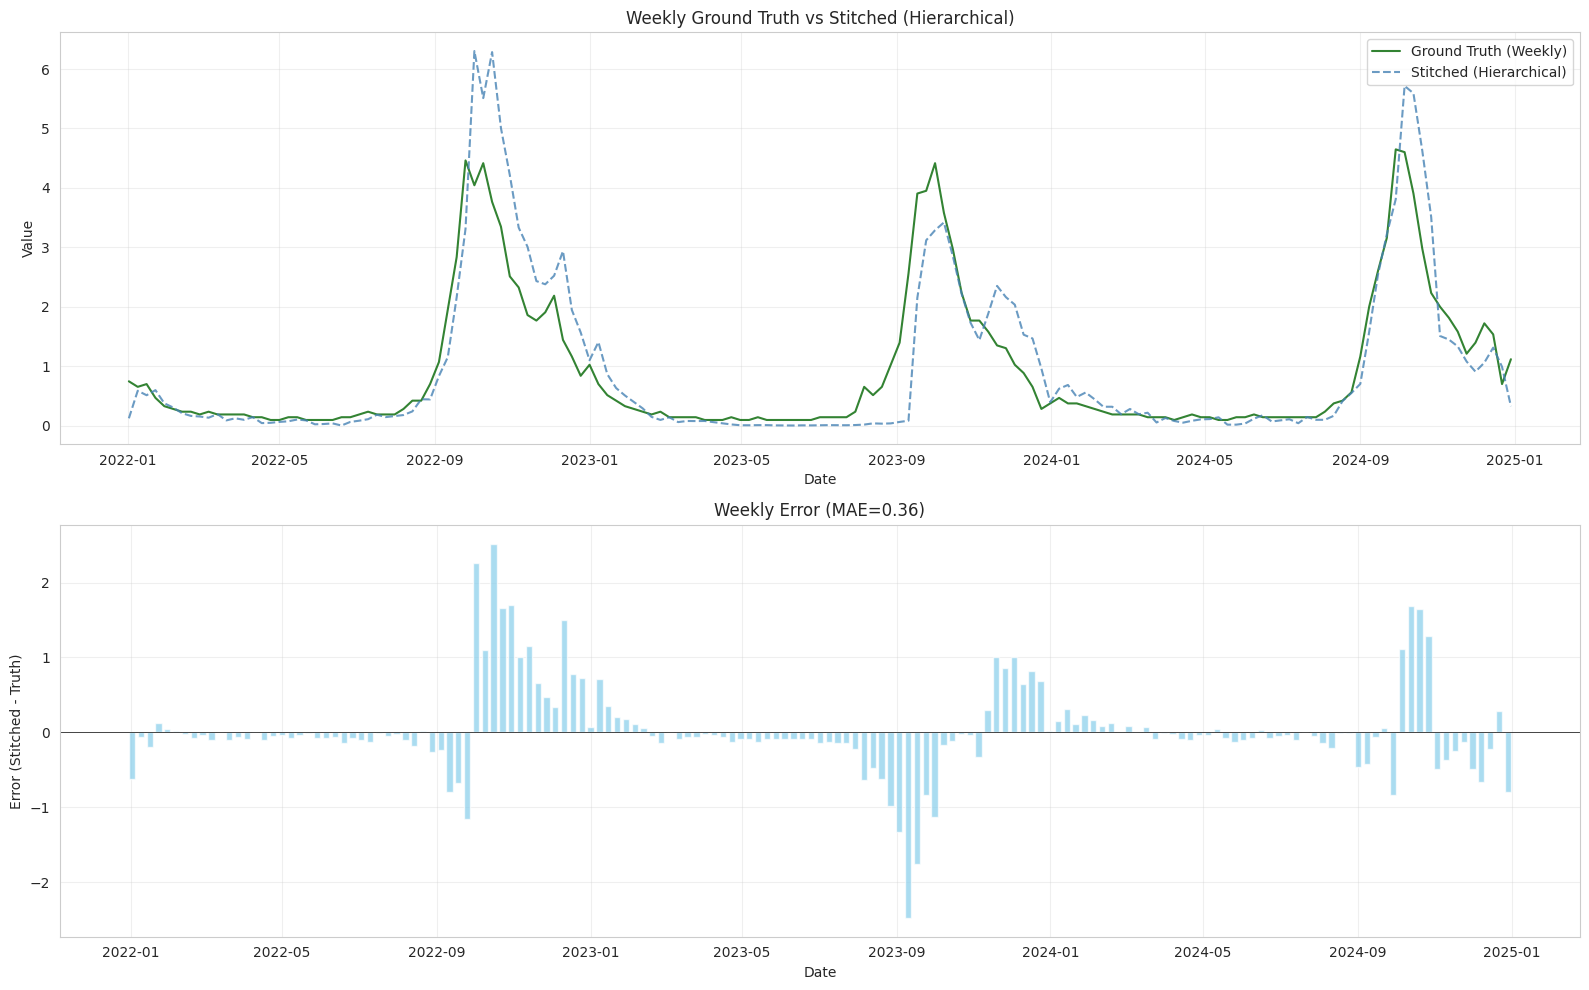

In [12]:
# Plot weekly comparison (if available)
if 'weekly_comparison' in result.diagnostics:
    weekly_comp = result.diagnostics['weekly_comparison']

    fig, axes = plt.subplots(2, 1, figsize=(16, 10))

    # Actual vs stitched
    axes[0].plot(weekly_comp['date'], weekly_comp['truth'],
                 linewidth=1.5, label='Ground Truth (Weekly)', alpha=0.8, color='darkgreen')
    axes[0].plot(weekly_comp['date'], weekly_comp['stitched'],
                 linewidth=1.5, linestyle='--', label='Stitched (Hierarchical)', alpha=0.8, color='steelblue')
    axes[0].set_xlabel('Date')
    axes[0].set_ylabel('Value')
    axes[0].set_title('Weekly Ground Truth vs Stitched (Hierarchical)')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Error plot
    axes[1].bar(weekly_comp['date'], weekly_comp['error'], alpha=0.7, color='skyblue', width=5)
    axes[1].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    axes[1].set_xlabel('Date')
    axes[1].set_ylabel('Error (Stitched - Truth)')
    axes[1].set_title(f"Weekly Error (MAE={result.diagnostics['weekly_mae']:.2f})")
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

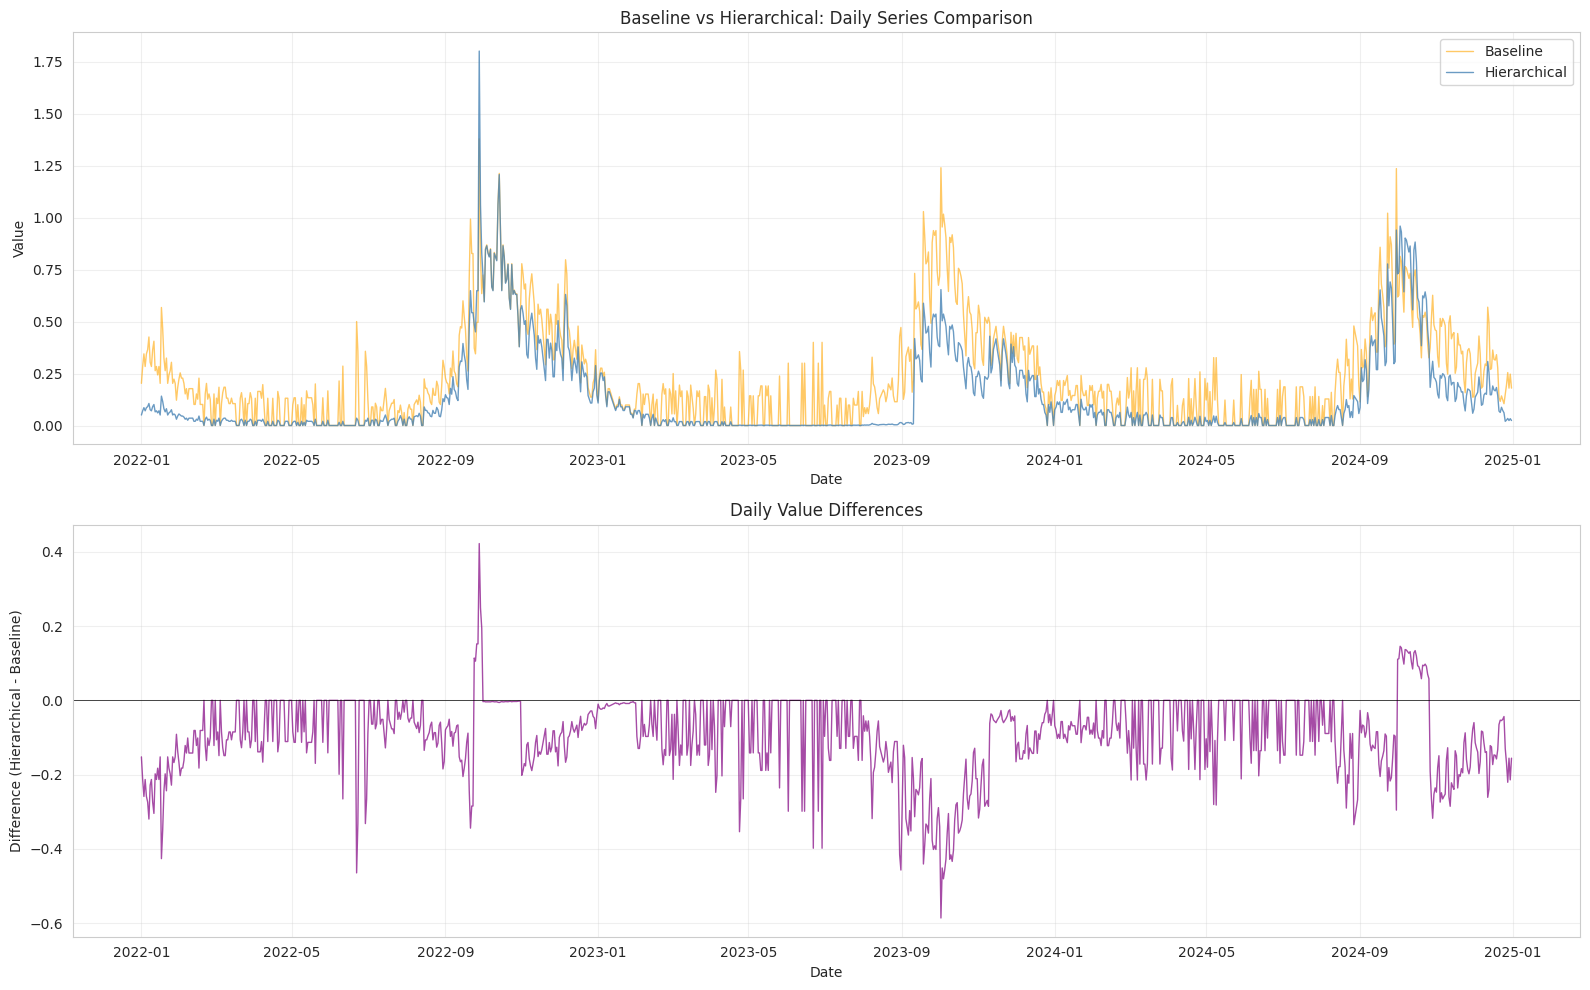

In [13]:
# Compare baseline vs hierarchical (if baseline available)
if baseline_result is not None:
    fig, axes = plt.subplots(2, 1, figsize=(16, 10))

    # Daily series comparison
    axes[0].plot(baseline_result.stitched_series['date'], baseline_result.stitched_series['value'],
                 linewidth=1, alpha=0.6, label='Baseline', color='orange')
    axes[0].plot(result.stitched_series['date'], result.stitched_series['value'],
                 linewidth=1, alpha=0.8, label='Hierarchical', color='steelblue')
    axes[0].set_xlabel('Date')
    axes[0].set_ylabel('Value')
    axes[0].set_title('Baseline vs Hierarchical: Daily Series Comparison')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Difference plot
    merged = pd.merge(
        baseline_result.stitched_series.rename(columns={'value': 'baseline'}),
        result.stitched_series.rename(columns={'value': 'hierarchical'}),
        on='date',
        how='inner'
    )
    merged['diff'] = merged['hierarchical'] - merged['baseline']

    axes[1].plot(merged['date'], merged['diff'], linewidth=1, alpha=0.7, color='purple')
    axes[1].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    axes[1].set_xlabel('Date')
    axes[1].set_ylabel('Difference (Hierarchical - Baseline)')
    axes[1].set_title('Daily Value Differences')
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

## 5. Save Results

In [15]:
# Save results
result.save(file_manager, "hierarchical")
logger.success(f"Results saved to {file_manager.interim / 'hierarchical'}")
print("\n✓ Hierarchical stitching complete!")

2025-11-12 23:48:25 | INFO     | Saved stitched series to /home/mikhailarutyunov/projects/google-trends-daily-data-preprocessing/interim/hierarchical/stitched_series.parquet
2025-11-12 23:48:25 | INFO     | Saved alpha estimates to /home/mikhailarutyunov/projects/google-trends-daily-data-preprocessing/interim/hierarchical/alpha_estimates.pkl
2025-11-12 23:48:25 | INFO     | Saved diagnostics to /home/mikhailarutyunov/projects/google-trends-daily-data-preprocessing/interim/hierarchical/diagnostics.pkl
2025-11-12 23:48:25 | SUCCESS  | Results saved to /home/mikhailarutyunov/projects/google-trends-daily-data-preprocessing/interim/hierarchical



✓ Hierarchical stitching complete!


## 6. Summary Statistics

In [16]:
# Create summary report
summary = f"""
HIERARCHICAL STITCHING SUMMARY
==============================

Search Term: {config.search_term}
Date Range: {config.date_range.start} to {config.date_range.end}
Overlap: {config.daily.overlap_days} days

DATA:
  Monthly observations: {len(monthly_data)}
  Weekly observations: {len(weekly_data) if weekly_data is not None else 'N/A'}
  Daily chunks: {len(daily_chunks)}
  Stitched daily points: {len(result.stitched_series)}

VALIDATION METRICS:

  ✅ MONTHLY (SOFT CONSTRAINTS - MEANINGFUL):
      MAE: {result.diagnostics.get('monthly_mae', 'N/A'):.2f} (Target: < 3.0)
      RMSE: {result.diagnostics.get('monthly_rmse', 'N/A'):.2f}
"""

if 'monthly_corr' in result.diagnostics:
    summary += f"      Correlation: {result.diagnostics['monthly_corr']:.3f}\n"
if 'monthly_nmae' in result.diagnostics:
    summary += f"      NMAE: {result.diagnostics['monthly_nmae']:.3f}\n"
if 'monthly_bias_pct' in result.diagnostics:
    summary += f"      Bias: {result.diagnostics['monthly_bias_pct']:.1f}%\n"

summary += """
      These metrics are meaningful because hierarchical uses soft
      constraints (weighted, not forced).
"""

if 'weekly_mae' in result.diagnostics:
    summary += f"""
  ✅ WEEKLY (INDEPENDENT VALIDATION - MEANINGFUL):
      MAE: {result.diagnostics['weekly_mae']:.2f} ⭐ (Target: < 1.5)
      RMSE: {result.diagnostics['weekly_rmse']:.2f}
"""
    if 'weekly_corr' in result.diagnostics:
        summary += f"      Correlation: {result.diagnostics['weekly_corr']:.3f} (pattern similarity)\n"
    if 'weekly_nmae' in result.diagnostics:
        summary += f"      NMAE: {result.diagnostics['weekly_nmae']:.3f} (scale-invariant)\n"
    if 'weekly_bias_pct' in result.diagnostics:
        summary += f"      Bias: {result.diagnostics['weekly_bias_pct']:.1f}% (systematic deviation)\n"

summary += f"""
ALPHA STATISTICS (Chunk-level):
  Mean: {result.diagnostics['alpha_mean']:.3f}
  Std: {result.diagnostics['alpha_std']:.3f}
  Min: {result.diagnostics['alpha_min']:.3f}
  Max: {result.diagnostics['alpha_max']:.3f}
  CV: {result.diagnostics['alpha_cv']:.3f}

OPTIMIZATION:
  Converged: {result.diagnostics['optimization']['converged']}
  Iterations: {result.diagnostics['optimization']['iterations']}
  Reason: {result.diagnostics['optimization']['stop_reason']}
"""

print(summary)

# Save summary to file
summary_path = file_manager.get_report_path("hierarchical_summary.txt")
with open(summary_path, 'w') as f:
    f.write(summary)
print(f"\nSummary saved to {summary_path}")


HIERARCHICAL STITCHING SUMMARY

Search Term: flu vaccine
Date Range: 2022-01-01 to 2024-12-31
Overlap: 60 days

DATA:
  Monthly observations: 263
  Weekly observations: 158
  Daily chunks: 6
  Stitched daily points: 1096

VALIDATION METRICS:

  ✅ MONTHLY (SOFT CONSTRAINTS - MEANINGFUL):
      MAE: 2.92 (Target: < 3.0)
      RMSE: 3.58
      Correlation: 0.935
      NMAE: 0.419
      Bias: -40.7%

      These metrics are meaningful because hierarchical uses soft
      constraints (weighted, not forced).

  ✅ WEEKLY (INDEPENDENT VALIDATION - MEANINGFUL):
      MAE: 0.36 ⭐ (Target: < 1.5)
      RMSE: 0.62
      Correlation: 0.902 (pattern similarity)
      NMAE: 0.391 (scale-invariant)
      Bias: 3.6% (systematic deviation)

ALPHA STATISTICS (Chunk-level):
  Mean: 0.167
  Std: 0.136
  Min: 0.009
  Max: 0.387
  CV: 0.810

OPTIMIZATION:
  Converged: True
  Iterations: 6
  Reason: x approximately solves least-squares problem


Summary saved to /home/mikhailarutyunov/projects/google-trends-